Scanning start dates: 100%|██████████| 8194/8194 [00:00<00:00, 13259.29it/s]



=== SPY First-Passage to -6.2% Drawdown ===
events_count: 3870
   mean_days: 97.53
 median_days: 54.00
    min_days: 1.00
    max_days: 504.00
    p10_days: 10.00
    p25_days: 21.00
    p75_days: 141.00
    p90_days: 254.00

Saved events to: spy_6p2_drawdown_events.csv
Columns: start_date, start_price, target_price, hit_date, hit_price, days_to_hit


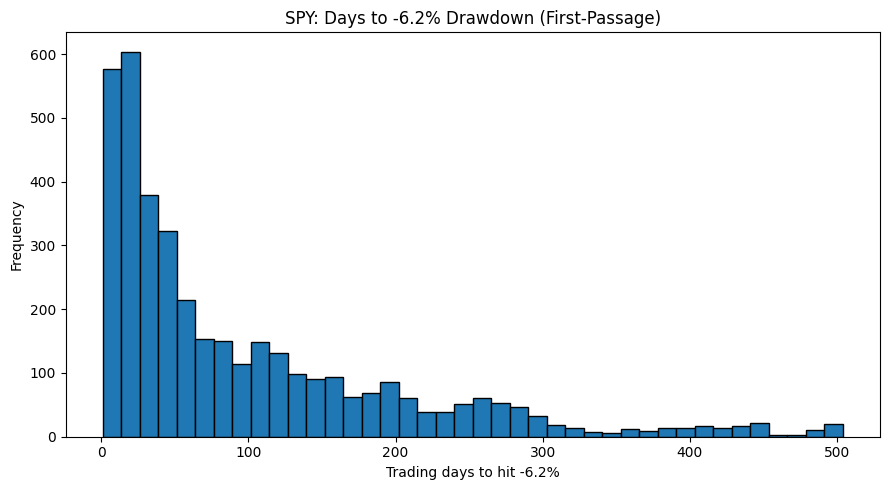

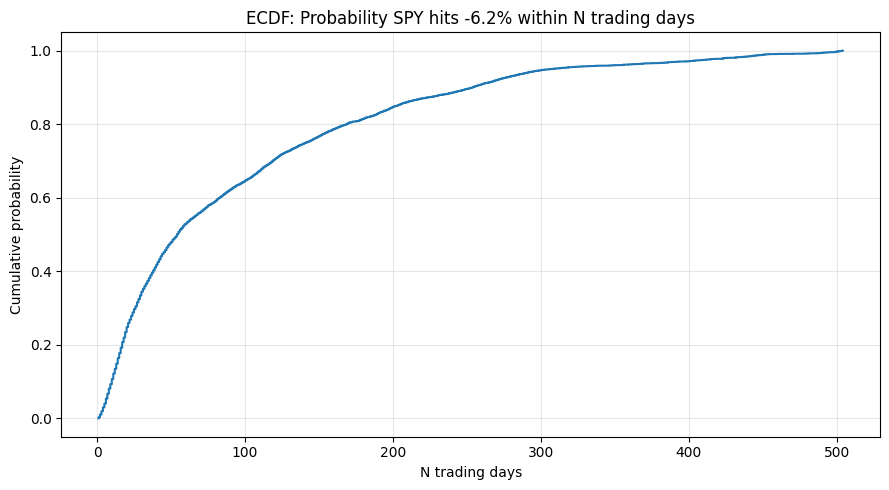

'\nret = prices.pct_change()\nrv_21 = ret.rolling(21).std() * np.sqrt(252)  # 21d annualized realized vol\n\n# Map realized vol at event start\nevents_df[\'rv21_at_start\'] = rv_21.reindex(dates).iloc[events_df.index].values\n\nhi_cut = rv_21.quantile(0.7)\nlo_cut = rv_21.quantile(0.3)\nhi = events_df[events_df[\'rv21_at_start\'] >= hi_cut][\'days_to_hit\']\nlo = events_df[events_df[\'rv21_at_start\'] <= lo_cut][\'days_to_hit\']\n\nprint(f"\nLow-vol median days: {np.median(lo):.1f} (n={len(lo)})")\nprint(f"High-vol median days: {np.median(hi):.1f} (n={len(hi)})")\n'

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
SPY -6.2% Drawdown First-Passage Times (with tqdm)
--------------------------------------------------
- Downloads SPY daily data (Adj-like using auto_adjust=True)
- For each start day, finds the first future day price <= start*(1-THRESH)
- Records the "days to hit" (first-passage time)
- Prints summary stats + percentiles
- Saves CSV of all events
- Plots histogram + ECDF

Install:
  pip install yfinance pandas numpy matplotlib tqdm
"""

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------------------- Params --------------------
TICKER = "SPY"
START  = "1993-01-01"
THRESH = 0.062          # 6.2% drop target
MAX_LOOKAHEAD = 252*2   # ~2 years of trading days (cap search for speed)
CSV_OUT = "spy_6p2_drawdown_events.csv"

# -------------------- Download --------------------
spy = yf.download(TICKER, start=START, interval="1d", auto_adjust=True, progress=False)

if "Close" not in spy.columns:
    raise RuntimeError("Downloaded data is missing 'Close' column.")

# Ensure we work with a 1-D price series (guard against n×1 dataframes)
prices = spy["Close"].astype(float).dropna().copy()
if isinstance(prices, pd.DataFrame):
    prices = prices.squeeze("columns")

assert prices.ndim == 1, f"Expected 1-D Series for prices, got ndim={prices.ndim}"
dates = prices.index
n = len(prices)
if n < 300:
    raise RuntimeError("Not enough price history downloaded to run the analysis.")

# -------------------- First-passage computation --------------------
durations = []
records = []

for i in tqdm(range(n-1), desc="Scanning start dates"):
    p0 = float(prices.iloc[i])                 # ensure scalar
    target = p0 * (1 - THRESH)

    j_end = min(i + 1 + MAX_LOOKAHEAD, n)
    future = prices.iloc[i+1:j_end]           # 1-D Series
    f_np = future.to_numpy().ravel()          # 1-D numpy array

    hit_idx = np.where(f_np <= target)[0]     # indices relative to future start
    if hit_idx.size > 0:
        j_rel = hit_idx[0] + 1                # +1 because future starts at i+1
        j = i + j_rel
        days = j - i
        durations.append(days)
        records.append({
            "start_date": dates[i].date(),
            "start_price": round(p0, 4),
            "target_price": round(target, 4),
            "hit_date": dates[j].date(),
            "hit_price": round(float(prices.iloc[j]), 4),
            "days_to_hit": int(days)
        })
    # else: no hit within lookahead -> ignore

durations = np.asarray(durations, dtype=float)

# -------------------- Summary stats --------------------
def pct(p):
    return float(np.percentile(durations, p)) if durations.size else np.nan

summary = {
    "events_count": int(durations.size),
    "mean_days": float(np.mean(durations)) if durations.size else np.nan,
    "median_days": float(np.median(durations)) if durations.size else np.nan,
    "min_days": float(np.min(durations)) if durations.size else np.nan,
    "max_days": float(np.max(durations)) if durations.size else np.nan,
    "p10_days": pct(10),
    "p25_days": pct(25),
    "p75_days": pct(75),
    "p90_days": pct(90),
}

print("\n=== SPY First-Passage to -6.2% Drawdown ===")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k:>12}: {v:.2f}")
    else:
        print(f"{k:>12}: {v}")

# -------------------- Save events --------------------
events_df = pd.DataFrame.from_records(records)
events_df.to_csv(CSV_OUT, index=False)
print(f"\nSaved events to: {CSV_OUT}")
if not events_df.empty:
    print("Columns:", ", ".join(events_df.columns))

# -------------------- Plots --------------------
if durations.size:
    # Histogram
    plt.figure(figsize=(9,5))
    plt.hist(durations, bins=40, edgecolor="black")
    plt.title("SPY: Days to -6.2% Drawdown (First-Passage)")
    plt.xlabel("Trading days to hit -6.2%")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # ECDF
    x = np.sort(durations)
    y = np.arange(1, len(x)+1) / len(x)

    plt.figure(figsize=(9,5))
    plt.plot(x, y, drawstyle="steps-post")
    plt.title("ECDF: Probability SPY hits -6.2% within N trading days")
    plt.xlabel("N trading days")
    plt.ylabel("Cumulative probability")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No events found within the lookahead window. Consider increasing MAX_LOOKAHEAD or adjusting THRESH.")

# -------------------- Optional: regime breakdown (uncomment to use) --------------------
"""
ret = prices.pct_change()
rv_21 = ret.rolling(21).std() * np.sqrt(252)  # 21d annualized realized vol

# Map realized vol at event start
events_df['rv21_at_start'] = rv_21.reindex(dates).iloc[events_df.index].values

hi_cut = rv_21.quantile(0.7)
lo_cut = rv_21.quantile(0.3)
hi = events_df[events_df['rv21_at_start'] >= hi_cut]['days_to_hit']
lo = events_df[events_df['rv21_at_start'] <= lo_cut]['days_to_hit']

print(f"\nLow-vol median days: {np.median(lo):.1f} (n={len(lo)})")
print(f"High-vol median days: {np.median(hi):.1f} (n={len(hi)})")
"""


The analysis of SPY daily data since 1993 shows that a 6.2% drawdown is a relatively common event, with 3,870 occurrences over the sample. On average, it takes about 98 trading days (roughly five months) for such a drop to materialize, though the typical case is quicker: the median is 54 trading days, or just over two months. The distribution is quite skewed. About 10% of drawdowns reach the 6.2% threshold within just two weeks, reflecting sharp market shocks such as the 2020 COVID crash or the 2015 yuan devaluation. A quarter of all cases occur within one month, while 75% are reached within seven months. At the other extreme, slow-burn corrections can stretch out over a year or more, with the maximum case in this dataset taking about two full years.

To visualize this distribution, we use an empirical cumulative distribution function (ECDF). An ECDF plots the cumulative probability that an event occurs within a given time horizon. For example, on the ECDF curve you can read off that about 25% of the time SPY drops 6.2% within a month, 50% within two to three months, and 90% within a year. Unlike a histogram, which shows frequencies in bins, the ECDF provides a smooth, step-like curve that directly answers “what’s the probability the drop happens in N days or less?”

Overall, the findings highlight two contrasting regimes. In periods of elevated volatility, the downside can materialize with surprising speed, sometimes in a single trading day. In calmer conditions, the same magnitude of decline typically unfolds gradually over weeks or months. This dual nature underscores the need for risk management frameworks that are robust to both rapid shocks and extended drawdowns.